<a href="https://colab.research.google.com/github/MohuaSinha/EVA4/blob/master/S10/S10_Solution_Main_GRADCAM_25MisclassifiedImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd "//content/gdrive/My Drive/Colab Notebooks/EVA4/Mou_Library"
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Mou_Library'
sys.path.append(workingdir)

/content/gdrive/My Drive/Colab Notebooks/EVA4/Mou_Library


In [3]:
ls-ltr

total 870
drwx------ 3 root root   4096 Mar 14 15:38 data/
-rw------- 1 root root   5348 Apr  4 20:51 datatransformation.py
-rw------- 1 root root    791 Apr  4 20:51 displayimages.py
-rw------- 1 root root    738 Apr  4 20:51 config.py
-rw------- 1 root root   2515 Apr  4 20:51 showimages.py
-rw------- 1 root root   1777 Apr  4 20:51 utils.py
-rw------- 1 root root   6998 Apr  4 20:51 train_test.py
-rw------- 1 root root   1125 Apr  4 20:51 plotresults.py
-rw------- 1 root root  19174 Apr  4 20:51 lr_finder.py
-rw------- 1 root root   9276 Apr  4 20:51 dnnmodel.py
-rw------- 1 root root   2826 Apr  5 14:38 gradcam.py
-rw------- 1 root root   3793 Apr  5 19:04 grad_visualize.py
drwx------ 2 root root   4096 Apr  5 19:06 __pycache__/
-rw------- 1 root root 824573 Apr  5 19:14 S10_Solution_Main.ipynb



Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [4]:
#!pip install import-ipynb
#import import_ipynb
#from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

%matplotlib inline
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from config import ModelConfig
import os

#Below are the created modules
import dnnmodel 
import train_test
import datatransformation 
import showimages
import displayimages
import  gradcam 
import grad_visualize 
import lr_finder
from utils import *
import plotresults
from torch.optim.lr_scheduler import StepLR

  pip install torch-lr-finder -v --global-option="amp"


**Model Configuration and set SEED**

In [5]:
# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 128,
  'dropout': 0.15,
  'epochs': 50,
  'l1_decay': 3e-06,
  'l2_decay': 0.001,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [0]:
#train_transforms,test_transforms= datatransformation.load()
train_transforms , test_transforms=datatransformation.AlbumentationWrapper('train'), datatransformation.AlbumentationWrapper('test')

In [7]:
classes,trainloader, testloader = datatransformation.dataloaders(1, 128, 10, train_transforms , test_transforms)

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



shape: torch.Size([128, 3, 32, 32])
  cat truck truck   cat   cat


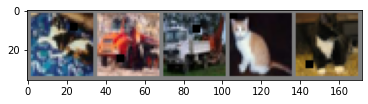

In [8]:
displayimages.show_random_image(trainloader,classes)

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [9]:
!pip install torchsummary
from torchsummary import summary

device = which_device()
model = dnnmodel.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
print(model.device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


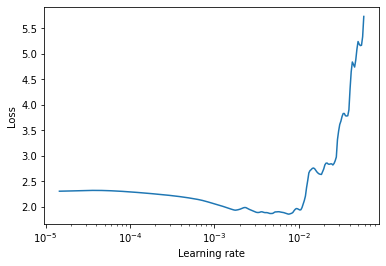

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
lr_finder =lr_finder.LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader,testloader, start_lr=1e-5,end_lr=2,num_iter=len(trainloader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [11]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))
args.lr = best_lr

Best Loss: 1.856429510511287
Best Learning Rate: 0.007485412741999116


In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
model =  dnnmodel.ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, threshold=0.004, patience = 1, verbose=True)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,verbose=True, min_lr=1e-5)
#epochs=1
input_size=(3,32,32)

In [0]:
def run(l1_decay=0.0, l2_decay=0.0):
  train_losses=[]
  test_losses = []
  train_accs=[]
  test_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(args.epochs):
      print("EPOCH:", epoch)
      train_test.train(model, device, trainloader, optimizer,scheduler, epoch,False,best_loss)
      train_test.test(model, device, testloader,criterion, classes, test_losses, test_accs,misclassified_imgs,correct_imgs,epoch==args.epochs-1)        
      scheduler.step(test_losses[-1])
  return train_losses, train_accs, test_losses, test_accs, misclassified_imgs,correct_imgs

In [16]:
# train and test the model
train_losses, train_accs, test_losses, test_accs, misclassified_imgs,correct_imgs = run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.8585977554321289 Batch_id=390 Accuracy=51.35: 100%|██████████| 391/391 [00:54<00:00,  7.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0082, Accuracy: 6283/10000 (62.83%)

EPOCH: 1


Loss=0.7545278668403625 Batch_id=390 Accuracy=71.05: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0061, Accuracy: 7259/10000 (72.59%)

EPOCH: 2


Loss=0.5853342413902283 Batch_id=390 Accuracy=78.23: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]

Epoch     5: reducing learning rate of group 0 to 7.4854e-04.



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0052, Accuracy: 7642/10000 (76.42%)

EPOCH: 3


Loss=0.4876840114593506 Batch_id=390 Accuracy=86.26: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0038, Accuracy: 8361/10000 (83.61%)

EPOCH: 4


Loss=0.2769683301448822 Batch_id=390 Accuracy=88.33: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]


Epoch     9: reducing learning rate of group 0 to 7.4854e-05.


  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0037, Accuracy: 8400/10000 (84.00%)

EPOCH: 5


Loss=0.4339149594306946 Batch_id=390 Accuracy=89.58: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8421/10000 (84.21%)

EPOCH: 6


Loss=0.3487350046634674 Batch_id=390 Accuracy=89.88: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]

Epoch    13: reducing learning rate of group 0 to 1.0000e-05.



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8421/10000 (84.21%)

EPOCH: 7


Loss=0.2628503143787384 Batch_id=390 Accuracy=89.93: 100%|██████████| 391/391 [00:55<00:00,  7.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8418/10000 (84.18%)

EPOCH: 8


Loss=0.36005693674087524 Batch_id=390 Accuracy=90.01: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8421/10000 (84.21%)

EPOCH: 9


Loss=0.17086830735206604 Batch_id=390 Accuracy=90.12: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8408/10000 (84.08%)

EPOCH: 10


Loss=0.23451772332191467 Batch_id=390 Accuracy=90.06: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8420/10000 (84.20%)

EPOCH: 11


Loss=0.23394009470939636 Batch_id=390 Accuracy=90.02: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8432/10000 (84.32%)

EPOCH: 12


Loss=0.163747638463974 Batch_id=390 Accuracy=90.11: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8420/10000 (84.20%)

EPOCH: 13


Loss=0.24050748348236084 Batch_id=390 Accuracy=90.01: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8428/10000 (84.28%)

EPOCH: 14


Loss=0.21884842216968536 Batch_id=390 Accuracy=90.05: 100%|██████████| 391/391 [00:55<00:00,  7.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8443/10000 (84.43%)

EPOCH: 15


Loss=0.2983103394508362 Batch_id=390 Accuracy=90.12: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8427/10000 (84.27%)

EPOCH: 16


Loss=0.4737775921821594 Batch_id=390 Accuracy=90.10: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8420/10000 (84.20%)

EPOCH: 17


Loss=0.23204942047595978 Batch_id=390 Accuracy=90.19: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8425/10000 (84.25%)

EPOCH: 18


Loss=0.45292720198631287 Batch_id=390 Accuracy=90.13: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8425/10000 (84.25%)

EPOCH: 19


Loss=0.2977794408798218 Batch_id=390 Accuracy=90.16: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8424/10000 (84.24%)

EPOCH: 20


Loss=0.3355860710144043 Batch_id=390 Accuracy=90.23: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8420/10000 (84.20%)

EPOCH: 21


Loss=0.2284565418958664 Batch_id=390 Accuracy=90.21: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8431/10000 (84.31%)

EPOCH: 22


Loss=0.23141467571258545 Batch_id=390 Accuracy=90.36: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8428/10000 (84.28%)

EPOCH: 23


Loss=0.2901950478553772 Batch_id=390 Accuracy=90.37: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8426/10000 (84.26%)

EPOCH: 24


Loss=0.3915117681026459 Batch_id=390 Accuracy=90.26: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8439/10000 (84.39%)

EPOCH: 25


Loss=0.3165438175201416 Batch_id=390 Accuracy=90.35: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8425/10000 (84.25%)

EPOCH: 26


Loss=0.341077983379364 Batch_id=390 Accuracy=90.29: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8423/10000 (84.23%)

EPOCH: 27


Loss=0.2418503314256668 Batch_id=390 Accuracy=90.44: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8425/10000 (84.25%)

EPOCH: 28


Loss=0.3003576397895813 Batch_id=390 Accuracy=90.30: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8434/10000 (84.34%)

EPOCH: 29


Loss=0.3243093490600586 Batch_id=390 Accuracy=90.48: 100%|██████████| 391/391 [00:55<00:00,  7.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8435/10000 (84.35%)

EPOCH: 30


Loss=0.2148667275905609 Batch_id=390 Accuracy=90.48: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8423/10000 (84.23%)

EPOCH: 31


Loss=0.16474267840385437 Batch_id=390 Accuracy=90.48: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8433/10000 (84.33%)

EPOCH: 32


Loss=0.24320459365844727 Batch_id=390 Accuracy=90.60: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8422/10000 (84.22%)

EPOCH: 33


Loss=0.2454335242509842 Batch_id=390 Accuracy=90.45: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8436/10000 (84.36%)

EPOCH: 34


Loss=0.23408889770507812 Batch_id=390 Accuracy=90.41: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8435/10000 (84.35%)

EPOCH: 35


Loss=0.2860139012336731 Batch_id=390 Accuracy=90.64: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8429/10000 (84.29%)

EPOCH: 36


Loss=0.2505488395690918 Batch_id=390 Accuracy=90.65: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8436/10000 (84.36%)

EPOCH: 37


Loss=0.22707423567771912 Batch_id=390 Accuracy=90.53: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8437/10000 (84.37%)

EPOCH: 38


Loss=0.34496188163757324 Batch_id=390 Accuracy=90.44: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8437/10000 (84.37%)

EPOCH: 39


Loss=0.2511064410209656 Batch_id=390 Accuracy=90.62: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8424/10000 (84.24%)

EPOCH: 40


Loss=0.3708053529262543 Batch_id=390 Accuracy=90.62: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8435/10000 (84.35%)

EPOCH: 41


Loss=0.1655450165271759 Batch_id=390 Accuracy=90.53: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8436/10000 (84.36%)

EPOCH: 42


Loss=0.4751926064491272 Batch_id=390 Accuracy=90.55: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8438/10000 (84.38%)

EPOCH: 43


Loss=0.23078899085521698 Batch_id=390 Accuracy=90.59: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8434/10000 (84.34%)

EPOCH: 44


Loss=0.17439445853233337 Batch_id=390 Accuracy=90.65: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8442/10000 (84.42%)

EPOCH: 45


Loss=0.2364424467086792 Batch_id=390 Accuracy=90.53: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8445/10000 (84.45%)

EPOCH: 46


Loss=0.22973427176475525 Batch_id=390 Accuracy=90.60: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8430/10000 (84.30%)

EPOCH: 47


Loss=0.23011398315429688 Batch_id=390 Accuracy=90.72: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8437/10000 (84.37%)

EPOCH: 48


Loss=0.39034414291381836 Batch_id=390 Accuracy=90.92: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8439/10000 (84.39%)

EPOCH: 49


Loss=0.3339759409427643 Batch_id=390 Accuracy=90.48: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]


Test set: Average loss: 0.0035, Accuracy: 8435/10000 (84.35%)



3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:   ship truck  ship  ship plane
Predicted:   ship truck  ship  ship plane


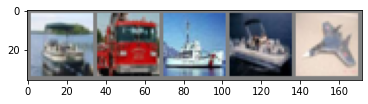

In [18]:
showimages.show_predicted_actual(model, device, testloader, classes)

Okay, now let us see what the neural network thinks these examples above are:



The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



## **Visualize GradCAM**

Use GradCAM to understand where the network is looking at while prediction

In [17]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = grad_visualize.VisualizeCam(model,classes, target_layers)
print (viz_cam)

In [19]:
#len(testloader.dataset)
print(misclassified_imgs[0]["img"])

tensor([[[ 0.2706,  0.2863,  0.3098,  ...,  0.3098,  0.3098,  0.3333],
         [ 0.2471,  0.2627,  0.2784,  ...,  0.3255,  0.3255,  0.3255],
         [ 0.2392,  0.2314,  0.2471,  ...,  0.3333,  0.3255,  0.3412],
         ...,
         [-0.1216, -0.0745, -0.0902,  ..., -0.0824, -0.0745, -0.0353],
         [-0.0431, -0.0353, -0.0196,  ...,  0.0039, -0.0353, -0.0431],
         [ 0.1451, -0.0353, -0.0039,  ..., -0.0431, -0.0745, -0.0980]],

        [[ 0.4980,  0.5059,  0.5294,  ...,  0.6314,  0.6314,  0.6549],
         [ 0.4667,  0.4824,  0.4980,  ...,  0.6549,  0.6471,  0.6549],
         [ 0.4667,  0.4510,  0.4667,  ...,  0.6627,  0.6549,  0.6706],
         ...,
         [-0.0824, -0.0824, -0.0588,  ..., -0.1451, -0.1451, -0.1059],
         [ 0.0039, -0.0510, -0.0118,  ..., -0.0431, -0.0980, -0.1059],
         [ 0.2078, -0.0588, -0.0353,  ..., -0.0824, -0.1059, -0.1294]],

        [[ 0.6706,  0.6784,  0.6941,  ...,  0.8510,  0.8510,  0.8824],
         [ 0.6392,  0.6549,  0.6706,  ...,  0

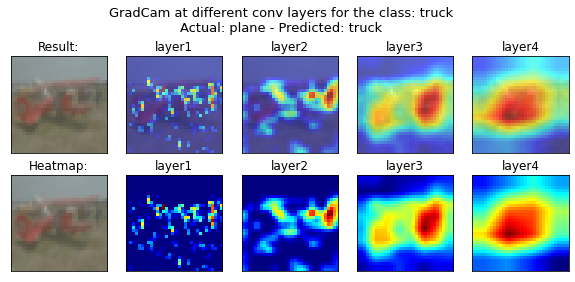

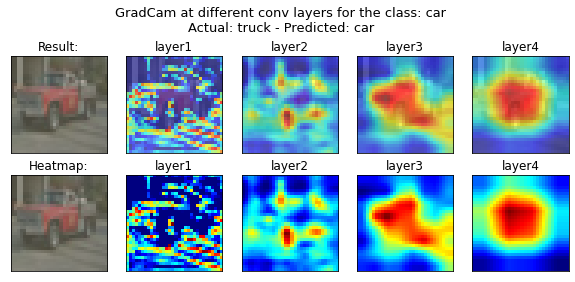

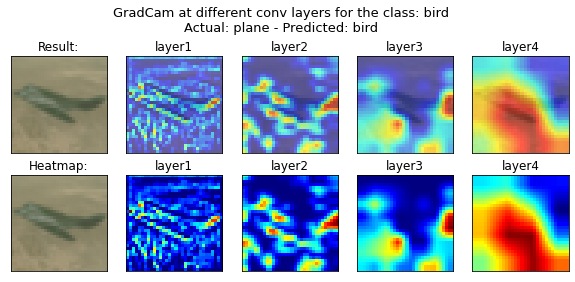

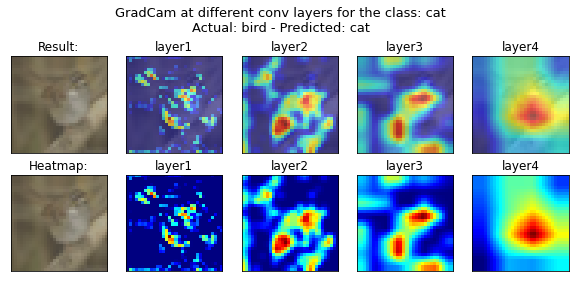

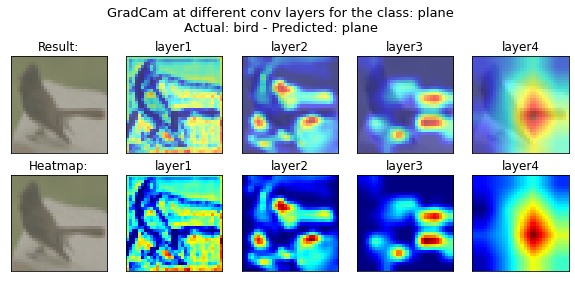

In [20]:
#GradCam for incorrectly classified images

num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
  #incorrect_pred_imgs
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")


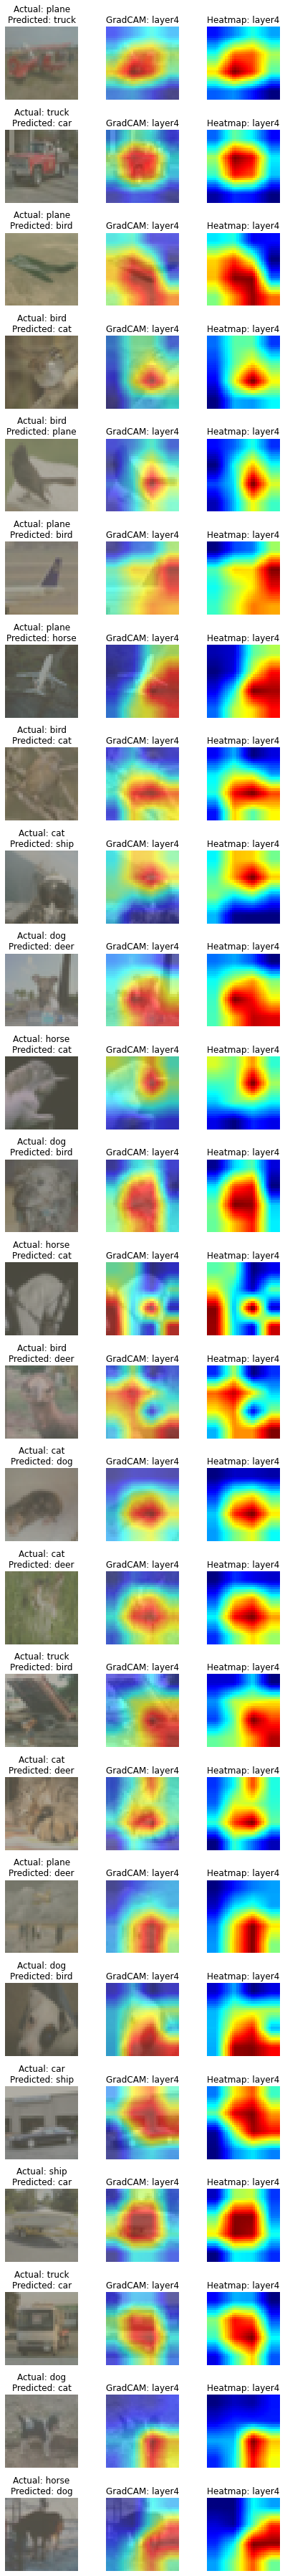

In [21]:
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect", per_image=False)

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [22]:
showimages.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 84 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [23]:
showimages.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 94 %
Accuracy of   car : 85 %
Accuracy of  bird : 80 %
Accuracy of   cat : 66 %
Accuracy of  deer : 76 %
Accuracy of   dog : 88 %
Accuracy of  frog : 81 %
Accuracy of horse : 95 %
Accuracy of  ship : 92 %
Accuracy of truck : 88 %


## **Plot Validation Accuracy**
Plot the change in validation accracy vs epochs

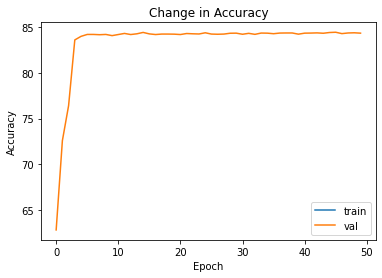

In [24]:
plt_data = {
    "train": train_accs,
    "val": test_accs
}
plotresults.plot_graph(plt_data, "Accuracy")